In [2]:
import json
import pandas as pd

# My custom processing lib
from data_preprocessing import DataPreprocess
from data_preprocessing.utils import ConfigTemplates

process_templates = ConfigTemplates()

import spacy

import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.feature_selection import chi2

from string import digits
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import datetime
import re  # For preprocessing
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

nlp = spacy.load("en_core_web_lg")
# !python -m spacy download en_trf_bertbaseuncased_lg
# nlp = spacy.load("en_trf_bertbaseuncased_lg")
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Load our data that was fetch from the api

In [3]:
consumer_df = pd.read_csv('../data/complaints.csv')

# Create subset of the data just for the past 3 years of BOA
sub_df = consumer_df[consumer_df.Company == 'BANK OF AMERICA, NATIONAL ASSOCIATION']


indexNames = sub_df[sub_df['Date received'] < '2019-01-01'].index
sub_df.drop(indexNames , inplace=True)


indexNames = sub_df[sub_df['Date received'] >= '2022-01-01'].index
sub_df.drop(indexNames , inplace=True)

# Format dates and calculate the number of days to respond
def respond(x):
    d = x['Date sent to company'] - x['Date received']
    return d.days

sub_df['Date received'] =  pd.to_datetime(sub_df['Date received'], format='%Y-%m-%d')
sub_df['Date sent to company'] =  pd.to_datetime(sub_df['Date sent to company'], format='%Y-%m-%d')
sub_df['Days to Respond'] = sub_df.apply(respond, axis = 1)

# Tag retail banking products
def retail(x):
    if x in ['Checking or savings account', 'Credit card or prepaid card', 'Payday loan, title loan, or personal loan']:
        return 'Retail'
    return 'Not Retail'
sub_df['Retail'] = sub_df['Product'].apply(retail)

# Method to get the year 
def get_year(x):
    year = x.year
    return year

sub_df['received_year'] = sub_df['Date received'].apply(get_year)

sub_df.fillna('',inplace=True)

In [25]:

sub_df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,...,Company response to consumer,Timely response?,Days to Respond,received_year,word_count,text_length,clean_narrative,features,category_id,Retail
12,2019-06-05,Credit card or prepaid card,General-purpose credit card or charge card,Fees or interest,Problem with fees,I have a bank of America small business credit...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",CA,92618,...,Closed with monetary relief,Yes,0,2019,101,456,bank america business credit card requested cl...,"[removed, raising, processed bank, charged ann...",0,Retail
81,2019-06-05,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Card was charged for something you did not pur...,I contacted Bank of America Visa to get help i...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",TX,75062,...,Closed with monetary relief,Yes,0,2019,886,4408,contacted bank america visa help ongoing issue...,"[cc, charge, dispute charge, compromised, fail...",0,Retail
153,2019-05-16,"Payday loan, title loan, or personal loan",Personal line of credit,Getting a line of credit,,,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",CA,91761,...,Closed with explanation,Yes,7,2019,0,0,,[],1,Retail
410,2019-05-30,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,XX/XX/2018 I contacted Bank of America to pay ...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30161,...,Closed with non-monetary relief,Yes,0,2019,212,1005,contacted bank america pay balance credit card...,"[late payment, credit, credit report, late, da...",2,Not Retail
436,2019-07-09,Credit card or prepaid card,General-purpose credit card or charge card,Trouble using your card,Can't use card to make purchases,XX/XX/XXXX B of A called to say our card was c...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",AZ,86338,...,Closed with non-monetary relief,Yes,1,2019,416,1863,called card compromised deny pmt dating servic...,"[provider, agent, card, monthly, credit, credi...",0,Retail


In [5]:
# Drop the columns we dont need to save memory
sub_df.drop(['Tags', 'Consumer disputed?', 'Complaint ID'], axis=1, inplace=True)

In [6]:
# Get Text Stats
def count_words(x):
    doc = nlp(str(x))
    wc = [token.text for token in doc]
    return len(wc)

def text_length(x):
    return len(str(x))

sub_df['word_count'] = sub_df['Consumer complaint narrative'].apply(count_words)
sub_df['text_length'] = sub_df['Consumer complaint narrative'].apply(text_length)

In [7]:
sub_df['word_count'].mean()

113.60450115186957

In [33]:
sub_df['text_length'].mean()

542.5631047315258

<AxesSubplot:xlabel='text_length', ylabel='Count'>

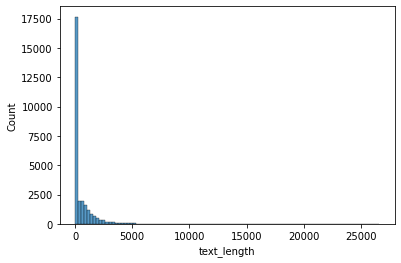

In [9]:
sns.histplot(sub_df['text_length'], bins=100)

In [10]:
sub_df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Days to Respond,received_year,word_count,text_length
12,2019-06-05,Credit card or prepaid card,General-purpose credit card or charge card,Fees or interest,Problem with fees,I have a bank of America small business credit...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",CA,92618,Consent provided,Web,2019-06-05,Closed with monetary relief,Yes,0,2019,101,456
81,2019-06-05,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Card was charged for something you did not pur...,I contacted Bank of America Visa to get help i...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",TX,75062,Consent provided,Web,2019-06-05,Closed with monetary relief,Yes,0,2019,886,4408
153,2019-05-16,"Payday loan, title loan, or personal loan",Personal line of credit,Getting a line of credit,,,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",CA,91761,Other,Web,2019-05-23,Closed with explanation,Yes,7,2019,0,0
410,2019-05-30,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,XX/XX/2018 I contacted Bank of America to pay ...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30161,Consent provided,Web,2019-05-30,Closed with non-monetary relief,Yes,0,2019,212,1005
436,2019-07-09,Credit card or prepaid card,General-purpose credit card or charge card,Trouble using your card,Can't use card to make purchases,XX/XX/XXXX B of A called to say our card was c...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",AZ,86338,Consent provided,Web,2019-07-10,Closed with non-monetary relief,Yes,1,2019,416,1863


In [11]:
# Using my custom data preprocessing lib I define a pipeline with all my cleaning steps
config = process_templates.pipeline()
config['data_loader'] = process_templates.data_loader_single_item_loader()
config['steps'].append(process_templates.normalize_text_lowercase())
# config['steps'].append(process_templates.normalize_text_debugger())
config['steps'].append(process_templates.normalize_text_remove_html())
config['steps'].append(process_templates.normalize_text_remove_stopwords(options="long_list"))
config['steps'].append(process_templates.normalize_text_expand_contractions())
config['steps'].append(process_templates.normalize_text_remove_digits())
config['steps'].append(process_templates.normalize_text_remove_punctuation())
config['steps'].append({
    "name": "normalize_text",
    "type": "remove_stopwords",
    "options": "custom",
    "custom_list": ["xx", "xxx", "xxxx", "xxxxx", "lending", "club", "boa", "not"]
})
config['steps'].append(process_templates.normalize_text_lemmatizer())
config['steps'].append(process_templates.normalize_text_remove_whitespace())

# Data preprocessing class
processor = DataPreprocess(config)

def process(x):
    data = processor.process_item(str(x))
    return data["data"]

sub_df['clean_narrative'] = sub_df['Consumer complaint narrative'].apply(process)

2022-01-08 10:03:52,303 - INFO - Validating Config 
2022-01-08 10:03:52,532 - INFO - Initializing nltk_regex tokenizer 
2022-01-08 10:03:52,536 - INFO - Initializing single_item data_loader 
2022-01-08 10:03:52,538 - INFO - Initializing lowercase normalize_text 
2022-01-08 10:03:52,543 - INFO - Initializing remove_html normalize_text 
2022-01-08 10:03:52,545 - INFO - Initializing remove_stopwords normalize_text 
2022-01-08 10:03:52,549 - INFO - Initializing expand_contractions normalize_text 
2022-01-08 10:03:52,551 - INFO - Initializing remove_digits normalize_text 
2022-01-08 10:03:52,553 - INFO - Initializing remove_punctuation normalize_text 
2022-01-08 10:03:52,554 - INFO - Initializing remove_stopwords normalize_text 
2022-01-08 10:03:52,555 - INFO - Initializing lemmatizer normalize_text 
2022-01-08 10:03:52,556 - INFO - Initializing remove_whitespace normalize_text 
2022-01-08 10:03:53,694 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10

2022-01-08 10:03:53,946 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:53,947 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:53,948 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:53,951 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:53,951 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:53,952 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:53,953 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:53,953 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:53,954 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:53,956 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:54,132 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,134 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,136 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,137 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,138 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,139 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,143 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,144 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,144 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,145 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:54,296 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,296 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,298 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,301 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,309 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,309 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,310 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,310 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,314 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,315 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:54,425 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,426 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,430 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,431 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,431 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,438 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,438 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,438 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,443 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,452 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:54,590 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,591 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,591 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,595 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,595 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,596 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,596 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,597 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,599 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,602 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:54,716 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,716 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,722 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,722 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,725 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,726 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,726 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,727 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,727 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,727 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:54,851 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,852 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,855 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,856 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,857 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,861 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,862 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,862 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,862 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:54,865 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:55,007 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,007 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,012 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,013 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,013 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,014 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,028 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,032 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,034 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,034 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:55,192 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,196 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,200 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,207 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,208 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,209 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,212 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,212 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,213 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,217 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:55,358 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,359 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,360 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,360 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,364 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,364 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,365 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,372 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,372 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,372 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:55,504 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,505 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,508 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,510 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,514 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,514 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,517 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,518 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,519 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,521 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:55,695 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,696 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,697 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,697 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,697 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,698 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,700 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,702 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,703 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,703 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:55,864 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,866 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,868 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,869 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,872 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,873 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,874 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,878 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,880 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:55,883 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:56,014 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,014 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,015 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,019 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,021 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,024 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,027 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,027 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,034 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,034 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:56,186 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,187 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,188 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,188 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,190 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,191 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,199 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,200 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,202 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,204 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:56,358 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,362 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,367 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,369 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,369 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,370 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,375 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,380 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,384 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,386 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:56,554 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,554 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,556 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,563 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,565 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,566 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,566 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,575 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,575 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,576 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:56,694 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,696 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,701 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,704 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,709 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,709 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,713 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,713 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,714 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,715 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:56,856 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,858 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,862 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,863 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,863 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,883 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,885 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,886 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,887 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:56,889 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:57,050 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,057 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,057 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,062 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,063 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,064 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,071 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,072 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,072 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,074 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:57,217 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,217 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,218 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,218 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,223 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,224 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,229 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,230 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,231 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,231 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:57,397 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,401 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,402 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,402 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,402 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,403 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,405 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,406 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,408 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,411 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:57,569 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,575 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,576 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,580 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,581 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,583 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,585 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,586 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,587 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,588 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:57,746 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,746 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,747 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,748 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,748 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,756 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,759 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,760 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,764 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,764 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:57,940 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,947 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,958 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,961 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,961 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,963 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,964 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,967 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,973 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:57,974 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:58,136 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,141 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,142 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,142 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,147 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,147 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,152 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,153 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,153 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,153 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:58,296 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,298 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,298 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,301 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,305 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,306 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,306 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,312 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,316 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,316 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:58,474 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,475 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,476 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,477 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,479 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,480 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,480 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,481 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,481 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,481 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:58,604 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,604 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,604 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,605 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,605 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,605 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,606 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,606 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,611 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,612 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:58,780 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,787 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,788 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,788 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,793 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,794 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,803 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,808 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,813 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,815 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:58,957 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,958 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,959 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,961 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,962 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,962 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,964 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,964 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,966 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:58,967 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:59,133 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,135 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,137 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,141 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,142 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,142 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,143 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,143 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,143 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,145 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:59,281 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,282 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,292 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,292 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,296 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,300 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,303 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,304 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,305 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,309 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:59,458 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,459 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,459 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,461 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,461 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,461 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,467 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,471 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,472 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,476 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:59,628 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,629 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,629 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,632 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,637 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,638 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,638 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,640 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,641 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,644 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:59,776 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,776 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,777 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,779 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,779 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,784 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,790 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,794 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,795 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,796 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:03:59,984 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,986 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,988 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,989 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,990 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,990 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,998 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:03:59,999 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,001 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,003 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:00,156 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,158 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,159 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,161 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,162 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,163 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,164 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,164 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,165 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,166 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:00,288 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,289 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,289 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,289 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,290 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,291 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,293 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,295 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,298 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,298 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:00,457 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,457 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,463 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,465 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,469 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,471 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,472 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,473 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,475 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,478 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:00,642 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,642 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,643 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,646 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,646 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,647 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,648 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,654 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,657 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,657 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:00,806 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,806 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,806 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,808 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,811 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,812 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,817 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,817 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,820 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,822 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:00,981 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,983 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,984 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,986 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,991 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,992 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:00,998 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,001 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,002 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,008 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:01,140 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,142 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,143 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,145 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,146 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,146 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,147 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,147 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,148 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,149 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:01,242 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,242 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,243 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,243 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,244 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,251 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,258 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,259 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,260 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,261 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:01,432 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,432 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,434 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,439 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,440 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,443 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,444 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,446 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,449 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,453 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:01,644 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,644 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,647 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,650 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,659 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,668 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,668 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,669 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,669 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,671 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:01,798 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,801 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,802 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,803 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,804 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,804 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,810 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,811 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,811 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,813 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:01,926 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,929 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,935 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,937 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,942 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,943 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,944 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,945 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,953 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:01,953 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:02,073 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,075 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,077 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,077 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,077 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,078 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,079 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,080 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,084 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,085 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:02,238 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,240 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,240 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,244 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,247 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,249 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,251 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,256 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,257 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,259 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:02,471 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,471 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,472 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,473 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,476 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,477 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,479 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,481 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,482 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,487 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:02,625 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,629 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,630 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,631 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,632 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,635 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,640 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,648 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,653 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,657 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:02,815 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,816 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,817 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,820 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,821 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,822 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,829 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,832 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,833 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,834 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:02,976 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,976 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,976 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,977 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,977 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,979 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,979 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,980 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,984 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:02,985 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:03,130 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,131 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,131 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,132 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,132 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,135 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,138 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,142 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,142 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,145 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:03,268 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,268 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,269 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,269 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,275 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,275 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,277 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,279 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,280 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,284 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:03,433 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,434 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,434 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,435 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,436 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,439 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,439 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,440 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,441 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,441 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:03,610 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,612 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,617 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,626 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,627 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,627 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,630 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,631 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,634 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,638 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:03,763 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,763 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,764 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,767 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,768 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,770 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,770 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,770 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,771 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,773 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:03,933 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,940 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,940 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,941 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,941 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,941 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,942 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,942 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,942 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:03,943 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:04,096 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,097 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,101 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,101 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,102 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,102 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,105 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,106 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,109 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,110 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:04,250 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,251 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,257 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,259 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,260 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,261 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,261 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,265 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,269 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,270 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:04,390 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,391 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,391 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,392 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,393 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,393 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,395 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,397 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,397 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,397 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:04,521 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,522 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,522 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,530 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,548 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,549 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,550 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,551 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,552 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,553 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:04,680 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,683 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,685 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,686 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,689 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,692 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,695 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,697 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,697 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,698 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:04,860 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,863 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,865 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,865 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,866 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,867 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,867 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,868 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,871 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:04,872 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:05,009 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,019 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,019 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,020 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,020 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,021 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,021 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,023 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,024 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,025 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:05,170 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,171 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,177 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,178 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,185 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,191 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,192 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,194 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,198 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,198 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:05,332 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,334 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,334 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,334 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,336 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,337 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,338 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,338 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,339 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,339 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:05,484 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,486 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,495 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,496 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,497 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,498 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,499 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,500 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,504 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,505 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:05,622 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,622 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,623 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,623 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,624 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,624 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,625 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,628 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,628 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,634 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:05,771 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,772 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,772 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,772 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,777 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,780 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,781 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,781 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,782 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,784 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:05,932 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,932 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,933 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,934 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,943 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,944 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,944 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,945 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,946 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:05,946 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:06,067 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,070 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,070 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,073 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,075 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,076 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,076 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,077 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,077 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,079 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:06,219 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,228 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,229 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,230 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,231 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,232 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,232 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,234 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,240 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,244 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:06,456 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,465 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,465 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,467 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,469 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,470 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,473 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,474 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,478 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,483 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:06,630 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,637 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,638 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,638 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,639 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,642 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,643 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,646 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,651 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,653 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:06,755 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,756 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,756 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,762 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,763 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,763 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,764 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,765 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,765 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,766 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:06,882 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,883 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,884 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,884 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,886 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,887 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,887 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,888 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,888 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:06,889 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:07,020 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,021 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,021 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,021 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,025 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,025 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,029 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,030 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,032 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,033 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:07,138 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,138 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,138 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,139 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,139 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,139 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,144 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,144 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,145 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,145 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:07,307 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,307 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,311 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,313 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,314 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,315 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,315 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,320 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,321 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,322 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:07,500 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,502 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,504 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,504 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,505 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,506 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,506 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,507 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,509 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,509 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:07,664 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,665 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,665 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,665 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,666 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,666 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,666 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,667 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,668 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,672 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:07,784 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,787 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,788 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,788 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,789 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,790 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,791 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,791 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,792 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,792 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:07,939 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,940 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,945 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,947 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,948 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,951 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,952 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,952 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,955 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:07,960 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:08,167 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,168 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,174 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,182 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,184 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,185 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,186 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,186 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,187 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,189 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:08,355 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,355 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,355 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,357 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,358 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,358 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,359 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,361 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,362 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,366 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:08,573 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,574 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,577 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,578 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,578 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,579 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,581 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,584 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,585 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,587 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:08,782 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,784 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,786 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,787 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,792 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,794 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,794 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,795 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,798 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,801 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:08,949 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,952 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,953 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,954 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,954 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,955 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,957 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,959 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,960 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:08,961 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:09,160 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,167 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,168 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,168 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,171 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,173 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,173 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,176 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,177 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,180 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:09,340 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,341 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,343 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,343 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,356 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,358 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,359 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,366 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,367 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,367 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:09,525 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,528 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,531 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,532 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,533 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,533 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,534 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,536 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,536 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,538 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:09,772 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,774 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,775 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,777 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,778 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,778 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,781 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,789 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,789 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,797 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:09,988 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,990 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,995 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:09,997 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,001 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,004 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,004 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,007 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,008 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,009 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:10,220 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,228 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,231 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,231 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,235 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,235 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,236 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,237 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,238 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,238 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:10,464 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,464 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,468 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,469 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,478 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,482 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,485 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,486 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,491 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,492 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:10,678 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,680 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,681 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,682 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,684 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,684 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,685 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,689 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,697 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,702 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:10,884 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,884 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,885 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,888 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,903 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,906 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,916 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,916 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,921 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:10,930 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:11,149 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,149 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,151 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,153 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,156 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,157 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,157 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,158 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,159 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,159 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:11,338 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,339 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,339 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,340 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,344 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,356 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,356 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,364 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,366 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,367 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:11,570 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,574 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,575 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,581 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,582 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,582 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,585 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,591 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,592 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,592 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:11,742 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,743 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,744 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,744 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,744 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,745 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,748 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,750 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,750 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,751 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:11,930 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,931 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,935 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,937 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,938 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,940 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,944 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,945 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,945 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:11,946 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:12,190 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,191 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,194 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,198 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,205 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,208 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,209 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,213 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,213 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,217 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:12,431 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,431 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,432 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,433 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,434 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,434 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,439 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,440 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,440 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,441 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:12,542 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,543 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,544 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,545 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,546 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,546 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,546 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,547 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,548 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,548 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:12,659 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,660 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,660 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,662 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,663 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,666 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,667 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,667 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,668 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,668 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:12,781 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,781 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,784 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,784 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,785 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,789 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,790 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,790 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,790 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,791 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:12,881 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,881 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,882 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,883 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,885 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,885 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,887 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,888 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,888 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,891 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:12,960 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,961 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,964 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,965 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,988 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,989 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,989 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,990 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,990 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:12,990 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:13,105 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,105 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,106 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,107 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,107 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,107 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,110 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,111 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,111 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,112 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:13,223 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,223 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,224 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,224 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,225 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,228 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,230 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,231 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,232 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,233 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:13,334 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,334 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,335 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,337 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,339 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,341 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,343 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,344 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,346 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,347 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:13,425 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,425 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,426 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,426 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,427 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,427 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,427 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,428 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,431 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,432 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:13,520 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,520 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,521 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,522 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,523 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,524 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,525 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,526 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,526 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,527 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:13,631 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,632 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,633 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,634 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,634 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,635 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,635 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,635 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,636 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,637 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:13,743 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,743 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,744 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,745 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,746 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,747 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,748 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,748 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,749 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,751 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:13,833 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,839 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,840 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,841 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,842 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,842 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,843 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,844 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,846 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,846 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:13,929 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,930 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,930 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,931 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,932 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,932 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,933 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,934 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,934 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:13,936 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:14,027 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,029 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,030 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,030 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,032 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,032 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,034 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,036 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,038 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,038 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:14,121 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,122 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,123 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,123 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,125 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,126 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,126 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,126 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,127 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,128 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:14,210 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,212 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,215 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,217 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,218 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,219 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,220 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,221 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,223 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,224 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:14,344 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,347 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,347 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,348 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,350 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,351 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,351 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,352 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,353 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,354 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:14,474 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,475 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,475 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,476 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,476 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,476 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,477 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,477 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,478 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,478 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:14,576 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,581 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,582 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,585 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,585 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,588 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,589 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,589 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,590 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,591 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:14,676 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,677 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,681 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,682 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,683 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,685 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,685 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,687 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,688 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,689 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:14,768 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,769 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,772 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,772 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,773 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,776 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,777 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,785 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,786 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,787 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:14,895 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,897 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,897 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,897 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,898 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,898 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,899 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,899 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,901 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:14,904 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:15,029 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,029 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,032 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,033 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,034 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,034 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,035 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,042 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,048 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,050 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:15,128 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,129 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,129 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,131 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,132 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,134 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,135 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,135 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,136 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,136 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:15,249 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,249 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,251 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,253 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,253 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,254 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,254 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,256 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,258 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,259 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:15,390 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,391 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,393 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,398 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,399 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,404 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,405 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,406 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,407 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,408 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:15,498 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,498 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,499 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,502 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,504 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,505 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,506 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,508 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,509 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,510 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:15,607 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,608 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,608 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,609 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,609 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,610 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,612 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,615 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,615 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,616 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:15,695 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,697 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,697 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,698 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,708 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,709 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,711 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,711 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,711 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,712 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:15,786 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,786 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,787 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,788 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,789 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,789 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,790 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,791 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,793 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,793 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:15,869 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,872 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,872 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,874 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,875 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,878 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,879 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,879 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,881 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:15,883 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:15,999 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,000 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,001 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,001 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,002 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,009 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,011 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,013 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,015 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,016 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:16,088 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,089 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,089 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,090 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,090 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,091 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,095 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,096 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,098 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,099 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:16,208 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,209 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,210 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,218 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,218 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,221 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,221 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,222 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,222 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,223 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:16,333 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,333 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,335 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,336 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,336 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,337 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,338 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,338 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,339 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,339 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:16,441 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,441 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,442 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,447 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,449 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,449 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,451 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,451 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,452 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,452 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:16,531 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,535 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,536 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,537 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,542 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,543 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,547 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,548 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,548 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,549 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:16,667 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,668 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,669 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,669 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,671 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,672 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,673 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,673 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,674 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,684 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:16,768 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,769 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,770 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,770 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,771 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,771 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,772 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,773 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,775 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,777 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:16,857 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,858 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,859 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,860 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,860 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,862 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,862 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,863 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,863 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,864 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:16,961 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,962 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,963 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,967 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,969 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,970 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,970 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,971 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,972 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:16,973 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:17,065 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,065 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,065 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,069 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,072 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,073 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,073 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,076 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,077 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,078 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:17,161 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,168 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,171 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,171 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,172 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,173 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,174 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,174 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,175 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,176 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:17,256 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,256 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,257 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,257 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,257 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,259 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,259 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,260 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,261 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,261 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:17,354 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,355 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,355 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,356 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,356 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,358 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,359 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,359 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,360 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,360 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:17,422 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,422 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,423 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,423 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,423 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,425 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,426 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,426 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,427 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,427 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:17,501 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,503 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,503 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,504 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,505 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,505 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,506 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,507 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,507 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,509 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:17,595 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,596 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,596 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,597 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,598 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,599 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,599 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,599 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,600 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,602 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:17,701 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,702 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,702 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,703 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,703 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,703 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,704 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,708 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,709 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,709 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:17,805 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,806 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,810 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,811 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,811 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,812 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,813 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,813 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,814 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,814 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:17,887 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,888 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,888 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,889 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,892 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,893 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,895 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,896 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,897 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,899 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:17,982 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,983 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,984 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,985 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,985 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,986 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,987 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,987 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,988 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:17,988 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:18,064 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,065 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,065 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,066 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,066 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,067 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,067 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,068 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,068 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,068 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:18,149 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,149 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,150 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,153 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,154 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,154 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,156 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,156 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,157 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,157 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:18,232 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,233 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,236 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,246 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,246 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,248 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,248 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,249 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,249 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,251 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:18,329 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,329 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,330 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,330 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,330 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,331 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,332 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,336 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,339 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,339 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:18,439 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,439 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,440 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,441 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,442 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,442 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,442 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,443 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,443 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,444 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:18,528 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,528 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,529 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,529 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,529 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,530 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,530 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,531 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,533 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,534 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:18,611 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,611 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,612 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,612 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,613 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,615 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,627 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,628 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,629 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,629 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:18,727 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,728 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,729 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,729 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,730 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,730 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,731 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,731 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,731 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,731 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:18,826 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,827 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,827 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,827 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,828 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,828 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,828 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,829 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,831 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,831 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:18,907 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,908 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,908 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,909 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,909 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,909 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,910 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,910 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,910 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:18,910 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:18,999 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,002 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,004 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,005 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,006 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,006 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,007 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,008 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,012 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,012 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:19,081 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,081 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,083 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,085 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,087 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,088 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,088 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,089 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,089 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,091 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:19,205 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,209 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,209 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,210 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,210 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,211 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,211 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,213 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,219 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,222 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:19,313 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,314 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,314 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,315 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,315 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,316 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,316 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,318 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,319 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,320 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:19,463 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,464 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,464 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,468 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,469 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,473 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,475 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,478 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,478 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,479 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:19,548 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,549 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,549 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,550 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,550 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,551 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,551 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,552 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,552 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,556 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:19,649 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,649 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,650 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,652 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,654 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,655 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,655 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,656 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,656 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,656 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:19,754 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,754 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,755 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,755 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,757 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,758 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,759 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,759 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,761 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,762 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:19,846 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,847 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,848 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,848 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,848 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,849 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,849 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,849 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,852 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,854 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:19,946 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,948 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,949 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,949 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,950 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,950 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,954 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,955 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,956 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:19,959 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:20,115 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,115 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,116 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,118 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,120 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,121 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,123 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,123 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,127 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,128 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:20,288 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,297 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,299 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,311 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,311 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,312 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,314 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,314 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,316 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,328 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:20,477 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,478 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,478 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,479 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,479 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,480 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,480 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,483 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,485 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,491 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:20,678 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,683 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,685 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,695 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,697 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,697 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,698 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,698 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,698 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,705 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:20,810 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,812 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,812 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,814 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,815 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,816 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,817 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,823 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,823 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,824 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:20,937 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,938 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,938 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,939 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,939 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,940 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,940 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,940 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,943 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:20,949 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:21,043 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,043 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,043 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,044 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,044 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,045 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,046 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,046 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,047 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,047 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:21,154 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,156 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,157 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,158 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,161 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,162 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,166 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,167 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,180 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,180 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:21,338 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,338 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,339 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,341 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,344 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,346 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,347 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,347 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,353 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,355 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:21,463 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,464 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,464 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,465 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,465 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,466 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,468 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,470 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,471 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,472 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:21,589 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,590 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,594 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,596 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,598 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,600 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,603 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,606 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,609 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,615 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:21,796 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,797 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,798 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,798 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,802 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,805 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,807 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,817 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,818 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,820 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:21,936 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,937 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,937 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,942 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,942 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,943 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,945 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,946 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,948 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:21,948 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:22,041 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,042 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,048 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,051 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,052 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,052 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,053 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,058 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,061 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,062 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:22,142 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,142 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,143 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,143 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,143 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,144 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,144 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,144 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,145 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,145 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:22,232 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,232 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,234 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,237 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,240 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,240 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,244 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,245 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,245 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,245 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:22,319 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,321 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,321 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,324 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,325 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,325 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,326 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,330 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,333 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,333 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:22,433 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,433 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,434 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,435 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,435 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,436 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,437 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,438 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,438 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,439 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:22,563 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,568 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,569 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,570 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,570 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,571 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,576 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,579 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,581 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,584 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


2022-01-08 10:04:22,697 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,698 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,698 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,699 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,699 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,699 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,706 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,707 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,707 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 
2022-01-08 10:04:22,707 - WARNING - No data not processing item (d41d8cd98f00b204e9800998ecf8427e) 


In [12]:
# Show cleaning example
for index, row in sub_df.iterrows():
    if row['Consumer complaint narrative']:
        print('Original')
        print(row['Consumer complaint narrative'])
        print('--------')
        print('Cleaned')
        print(row['clean_narrative'])
        break

Original
I have a bank of America small business credit card that I had requested to close. However it was not never processed and the bank charged me the annual fee and late payment fee for XXXX ( from XX/XX/XXXX till XX/XX/XXXX ). I was out of USA during this period and once I returned I visited the branch in XXXX CA multiple times to get this resolved. I was told the charges will be removed but never got these removed so far. Hence I am raising the complain.
--------
Cleaned
bank america business credit card requested close processed bank charged annual fee late payment fee till usa period returned visited branch ca multiple time resolved told charge removed removed far hence am raising complain


In [13]:
# Feature Extraction

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)


def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""

    # use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    # word index and corresponding tf-idf score
    for idx, score in sorted_items:

        # keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    # create a tuples of feature,score
    # results = zip(feature_vals,score_vals)
    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]] = score_vals[idx]

    return results


def get_tfidf(transformer, cv_model, features, doc):
    # generate tf-idf for the given document
    tf_idf_vector = transformer.transform(cv_model.transform([doc]))

    # sort the tf-idf vectors by descending order of scores
    sorted_items = sort_coo(tf_idf_vector.tocoo())

    # extract only the top n; n here is 10
    keywords = extract_topn_from_vector(features, sorted_items, 10)
    return [k for k in keywords]


def make_model(data):
    """Make tfidf model"""
    updated_data = []
    for index, row in data.iterrows():
        updated_data.append(row['clean_narrative'])

    cv = CountVectorizer(
        max_df=0.85,
        max_features=10000,
        ngram_range=(1, 2)
    )
    word_count_vector = cv.fit_transform(updated_data)

    tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
    tfidf_transformer.fit(word_count_vector)

    feature_names = cv.get_feature_names()

    return cv, tfidf_transformer, feature_names

cv, tfidf_transformer, feature_names = make_model(sub_df)

# Extract features
def feature_extraction(text):
    return get_tfidf(tfidf_transformer, cv, feature_names, text)

sub_df['features'] = sub_df['clean_narrative'].apply(feature_extraction)

In [14]:
# Show Features
for index, row in sub_df.iterrows():
    if row['Consumer complaint narrative']:
        print('Original')
        print(row['Consumer complaint narrative'])
        print('--------')
        print('Cleaned')
        print(row['clean_narrative'])
        print('--------')
        print('Features')
        print(row['features'])
        break

Original
I have a bank of America small business credit card that I had requested to close. However it was not never processed and the bank charged me the annual fee and late payment fee for XXXX ( from XX/XX/XXXX till XX/XX/XXXX ). I was out of USA during this period and once I returned I visited the branch in XXXX CA multiple times to get this resolved. I was told the charges will be removed but never got these removed so far. Hence I am raising the complain.
--------
Cleaned
bank america business credit card requested close processed bank charged annual fee late payment fee till usa period returned visited branch ca multiple time resolved told charge removed removed far hence am raising complain
--------
Features
['removed', 'raising', 'processed bank', 'charged annual', 'fee late', 'card requested', 'branch ca', 'visited branch', 'charge removed', 'bank charged']


In [15]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

corpus = []
for index, row in sub_df.iterrows():
    corpus.extend(row.features)
    

top_words = get_top_n_words(corpus, n=500)
top_words


[('account', 7234),
 ('bank', 6242),
 ('america', 4286),
 ('credit', 3872),
 ('card', 3551),
 ('payment', 2432),
 ('money', 1991),
 ('check', 1739),
 ('claim', 1636),
 ('charge', 1543),
 ('fee', 1367),
 ('day', 1333),
 ('report', 1267),
 ('time', 1201),
 ('fraud', 1183),
 ('am', 1165),
 ('transaction', 1109),
 ('fund', 1104),
 ('told', 1093),
 ('loan', 945),
 ('balance', 937),
 ('late', 929),
 ('received', 864),
 ('called', 851),
 ('information', 835),
 ('call', 833),
 ('closed', 821),
 ('amount', 819),
 ('identity', 791),
 ('theft', 757),
 ('mortgage', 750),
 ('letter', 676),
 ('transfer', 668),
 ('pay', 645),
 ('due', 640),
 ('company', 638),
 ('month', 630),
 ('sent', 618),
 ('deposit', 608),
 ('bofa', 606),
 ('dispute', 603),
 ('fraudulent', 600),
 ('paid', 584),
 ('reporting', 559),
 ('checking', 558),
 ('debt', 556),
 ('business', 528),
 ('statement', 524),
 ('date', 517),
 ('debit', 514),
 ('atm', 514),
 ('hold', 503),
 ('service', 492),
 ('refund', 482),
 ('phone', 479),
 ('com

In [41]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=500,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [ ]:
sub_df.info()

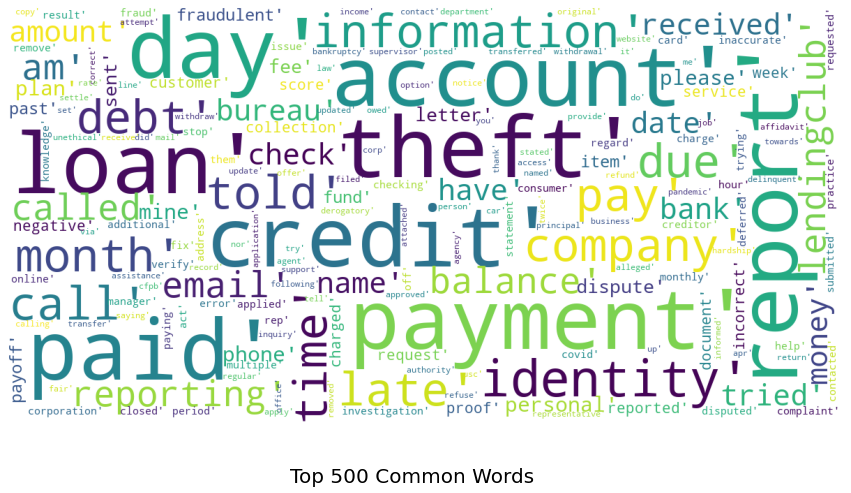

In [53]:
show_wordcloud(top_words,'Top 500 Common Words')

In [38]:
# Correlation of terms by product
# Create a new column 'category_id' with encoded categories 
sub_df['category_id'] = sub_df['Product'].factorize()[0]
category_id_df = sub_df[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)


sub_df.head()

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(sub_df.clean_narrative).toarray()

labels = sub_df.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

# Finding the three most correlated terms with each of the product categories
N = 5
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(Product))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

Each of the 28215 complaints is represented by 31088 features (TF-IDF score of unigrams and bigrams)

==> Checking or savings account:
  * Most Correlated Unigrams are: overdraft, mortgage, deposit, payment, credit
  * Most Correlated Bigrams are: late payment, overdraft fee, checking account, credit report, credit card

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: reward, credit, edd, charge, card
  * Most Correlated Bigrams are: balance transfer, card account, card bank, america credit, credit card

==> Credit reporting, credit repair services, or other personal consumer reports:
  * Most Correlated Unigrams are: credit, theft, reporting, report, inquiry
  * Most Correlated Bigrams are: inquiry credit, account identity, bk amer, identity theft, credit report

==> Debt collection:
  * Most Correlated Unigrams are: fdcpa, collect, collector, collection, debt
  * Most Correlated Bigrams are: collect debt, fair debt, debt collector, collection practice, debt collect

Each of the 28215 complaints is represented by 31088 features (TF-IDF score of unigrams and bigrams)


In [37]:
# Correlation of terms by issue
# Create a new column 'category_id' with encoded categories 
sub_df['category_id'] = sub_df['Product'].factorize()[0]
category_id_df = sub_df[['Issue', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Issue']].values)


sub_df.head()

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(sub_df.clean_narrative).toarray()

labels = sub_df.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

# Finding the three most correlated terms with each of the issue categories
N = 5
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(Product))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Advertising:
  * Most Correlated Unigrams are: reward, credit, edd, charge, card
  * Most Correlated Bigrams are: balance transfer, card account, card bank, america credit, credit card

==> Advertising and marketing, including promotional offers:
  * Most Correlated Unigrams are: reward, credit, edd, charge, card
  * Most Correlated Bigrams are: balance transfer, card account, card bank, america credit, credit card

==> Applying for a mortgage or refinancing an existing mortgage:
  * Most Correlated Unigrams are: property, escrow, modification, loan, mortgage
  * Most Correlated Bigrams are: loan officer, mortgage bank, escrow account, loan modification, mortgage payment

==> Attempts to collect debt not owed:
  * Most Correlated Unigrams are: fdcpa, collect, collector, collection, debt
  * Most Correlated Bigrams are: collect debt, fair debt, debt collector, collection practice, debt collection

==> Can't contact lender or servicer:
  * Most Correlated Unigrams are: loan, nonprof


==> Other transaction problem:
  * Most Correlated Unigrams are: scammed, scammer, scam, wire, transfer
  * Most Correlated Bigrams are: transfer money, sent money, international wire, money transfer, wire transfer

==> Overdraft, savings, or rewards features:
  * Most Correlated Unigrams are: scammed, scammer, scam, wire, transfer
  * Most Correlated Bigrams are: transfer money, sent money, international wire, money transfer, wire transfer

==> Problem caused by your funds being low:
  * Most Correlated Unigrams are: overdraft, mortgage, deposit, payment, credit
  * Most Correlated Bigrams are: late payment, overdraft fee, checking account, credit report, credit card

==> Problem getting a card or closing an account:
  * Most Correlated Unigrams are: reward, credit, edd, charge, card
  * Most Correlated Bigrams are: balance transfer, card account, card bank, america credit, credit card

==> Problem when making payments:
  * Most Correlated Unigrams are: loan, nonprofit, dmv, forgiven